In [29]:
import re
import numpy as np
import pandas as pd
from scipy.stats import skew, stats, normaltest, probplot

import impyute as impy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
housing = pd.read_csv("Data/Melbourne_housing_EDA.csv")
housing.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,-9999.0,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,-9999.0,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


## Incomplete features

### 1.	Detection of missing values

**1.	Missing values encoded as NaN, NaT, or None. **

In [3]:
python_nan = {col:housing[col].isnull().sum() for col in housing.columns}
python_nan

{'Suburb': 0,
 'Address': 0,
 'Rooms': 0,
 'Type': 0,
 'Price': 0,
 'Method': 0,
 'SellerG': 0,
 'Date': 0,
 'Distance': 1,
 'Postcode': 0,
 'Bedroom2': 0,
 'Bathroom': 0,
 'Car': 8728,
 'Landsize': 11810,
 'BuildingArea': 21115,
 'YearBuilt': 19306,
 'CouncilArea': 1397,
 'Lattitude': 7976,
 'Longtitude': 7976,
 'Regionname': 3,
 'Propertycount': 3}

**2.	Missing values encoded in some non-standard way that is described in the data dictionary.** 

In [4]:
str_nan_dict = {col : np.sum(housing[col].isin(["notavailable", "missing"])) 
                                   if np.dtype(housing[col])==object 
                                   else "is numeric" for col in housing.columns}
str_nan_dict

{'Suburb': 0,
 'Address': 0,
 'Rooms': 'is numeric',
 'Type': 0,
 'Price': 'is numeric',
 'Method': 0,
 'SellerG': 0,
 'Date': 0,
 'Distance': 'is numeric',
 'Postcode': 280,
 'Bedroom2': 0,
 'Bathroom': 8226,
 'Car': 'is numeric',
 'Landsize': 'is numeric',
 'BuildingArea': 'is numeric',
 'YearBuilt': 'is numeric',
 'CouncilArea': 0,
 'Lattitude': 'is numeric',
 'Longtitude': 'is numeric',
 'Regionname': 0,
 'Propertycount': 'is numeric'}

In [5]:
num_nan_dict = {col : np.sum(housing[col].isin([-9999,0])) 
                if np.dtype(housing[col])!=object 
                else "is text" for col in housing.columns}
num_nan_dict

{'Suburb': 'is text',
 'Address': 'is text',
 'Rooms': 0,
 'Type': 'is text',
 'Price': 7610,
 'Method': 'is text',
 'SellerG': 'is text',
 'Date': 'is text',
 'Distance': 77,
 'Postcode': 'is text',
 'Bedroom2': 'is text',
 'Bathroom': 'is text',
 'Car': 1631,
 'Landsize': 2437,
 'BuildingArea': 76,
 'YearBuilt': 0,
 'CouncilArea': 'is text',
 'Lattitude': 0,
 'Longtitude': 0,
 'Regionname': 'is text',
 'Propertycount': 0}

**3.	Missing values of a numeric feature encoded as a string that is not described in the data dictionary**

In [6]:
num_nan = {col:{'type':np.dtype(housing[col]).name, 'sample':housing.loc[100,col]} 
           for col in housing.columns}
pd.DataFrame(data=num_nan).T

,type,sample
Suburb,object,Airport West
Address,object,180 Parer Rd
Rooms,int64,3
Type,object,h
Price,float64,830000.0
Method,object,S
SellerG,object,Barry
Date,object,16/04/2016
Distance,float64,13.5
Postcode,object,3042.0


In [7]:
for col in ['Bathroom','Bedroom2', 'Postcode']:
    missing = np.unique([i for i in housing[col] 
                              if re.match(r'^[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$', i) is None])
    print(col, missing)

Bathroom ['notavailable']
Bedroom2 ['-']
Postcode ['missing']


**4.	Missing values of a numeric feature encoded as an extreme numeric value.**

In [8]:
extremes_num = {col : {'max_value': np.max(housing[col]), 
                           'min_value': np.min(housing[col])}  
                    for col in housing.columns 
                    if np.dtype(housing[col])!=object}
pd.DataFrame(data=extremes_num).T

,max_value,min_value
Rooms,1.600000e+01,1.00000
Price,1.120000e+07,-9999.00000
Distance,4.810000e+01,0.00000
Car,2.600000e+01,0.00000
Landsize,4.330140e+05,0.00000
BuildingArea,4.451500e+04,0.00000
YearBuilt,2.106000e+03,1196.00000
Lattitude,-3.739020e+01,-38.19043
Longtitude,1.455264e+02,144.42379
Propertycount,2.165000e+04,83.00000


**5.	Missing values in non-numeric  column encoded as a string that is not described in the data dictionary. **

In [9]:
categorical_dictionary = {'Type' : ['br','h','u','t','dev site','o res']}
nondictionary_cat = {col: np.unique([housing.loc[i,col] for i in housing[col].index 
                                             if not housing.loc[i,col] in categorical_dictionary[col]]) 
                             for col in housing.columns if col in categorical_dictionary.keys()}
nondictionary_cat

{'Type': array(['UNK'], dtype='<U3')}

### 2.	Missing values encoding

In [10]:
housing_nan = housing.applymap(lambda x: np.nan if x in ['notavailable','missing','-','UNK',-9999] else x)
housing_nan['BuildingArea'] = housing_nan['BuildingArea'].replace(0, np.nan)
housing_nan['YearBuilt'] = [value if value<=2016 else np.nan for value in housing_nan['YearBuilt']]
housing_nan.fillna(value = np.nan, inplace = True)

In [11]:
housing_nan = housing_nan.astype({'Suburb': object, 
                                 'Address':object, 
                                 'Rooms':np.number, 
                                 'Type':object, 
                                 'Price':np.number, 
                                 'Method':object,
                                 'SellerG': object,
                                 'Distance': np.number,
                                 'Postcode':  np.number, 
                                 'Bedroom2': np.number, 
                                 'Bathroom': np.number, 
                                 'Car': np.number,
                                 'Landsize': np.number, 
                                 'BuildingArea': np.number, 
                                 'CouncilArea': object, 
                                 'Lattitude': np.number,
                                 'Longtitude': np.number, 
                                 'Regionname': object, 
                                 'YearBuilt' : object ,
                                 'Propertycount': np.number})
housing_nan['Date'] = pd.to_datetime(housing_nan['Date'])

/Users/nikiathanasiadou/EDAwPython/myenv/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13/08/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/nikiathanasiadou/EDAwPython/myenv/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '14/05/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/nikiathanasiadou/EDAwPython/myenv/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '15/10/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/nikiathanasiadou/EDAwPython/myenv/lib/python3.8/site-packages/pandas/core/t

In [12]:
housing_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         34857 non-null  object        
 1   Address        34857 non-null  object        
 2   Rooms          34857 non-null  float64       
 3   Type           32417 non-null  object        
 4   Price          27247 non-null  float64       
 5   Method         34857 non-null  object        
 6   SellerG        34857 non-null  object        
 7   Date           34857 non-null  datetime64[ns]
 8   Distance       34856 non-null  float64       
 9   Postcode       34577 non-null  float64       
 10  Bedroom2       26640 non-null  float64       
 11  Bathroom       26631 non-null  float64       
 12  Car            26129 non-null  float64       
 13  Landsize       23047 non-null  float64       
 14  BuildingArea   13666 non-null  float64       
 15  YearBuilt      1546

### 3.	Deciding on a strategy
**2.	Evaluating the extend of the problem. **

In [13]:
pct = pd.DataFrame(data ={'col_name' :housing_nan.columns,  
                          'pct_detected_nan' :  [round((housing_nan[col].isnull().sum())*100/housing_nan.shape[0],3) 
                                                 for col in housing_nan.columns]})
pct.sort_values(by='pct_detected_nan',inplace=True)
pct = pd.concat([pct, 
                 pd.DataFrame(data={'col_name': ['All'],
                                         'pct_detected_nan': round(np.average(pct['pct_detected_nan'].values),3)}
                             )
                ]
               )
pct

,col_name,pct_detected_nan
0,Suburb,0.000
1,Address,0.000
2,Rooms,0.000
5,Method,0.000
6,SellerG,0.000
7,Date,0.000
8,Distance,0.003
19,Regionname,0.009
20,Propertycount,0.009
9,Postcode,0.803


**3.	Understanding the patterns of missingness.**

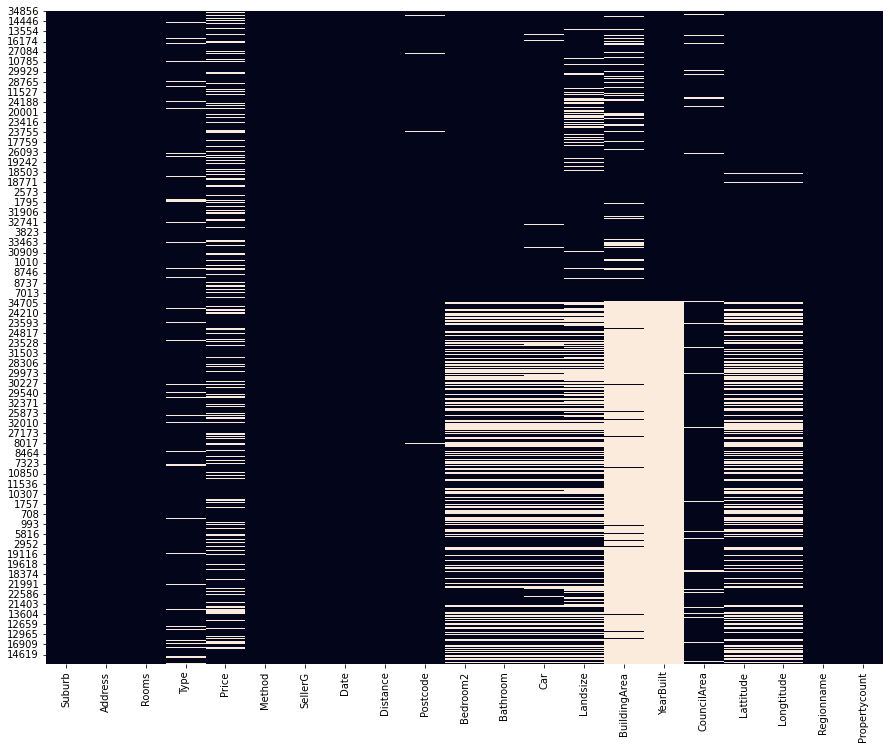

In [14]:
matplotlib.rcParams['figure.figsize'] = [15,12]
sns.heatmap(housing_nan.isnull().sort_values(by="YearBuilt"), cbar=False);

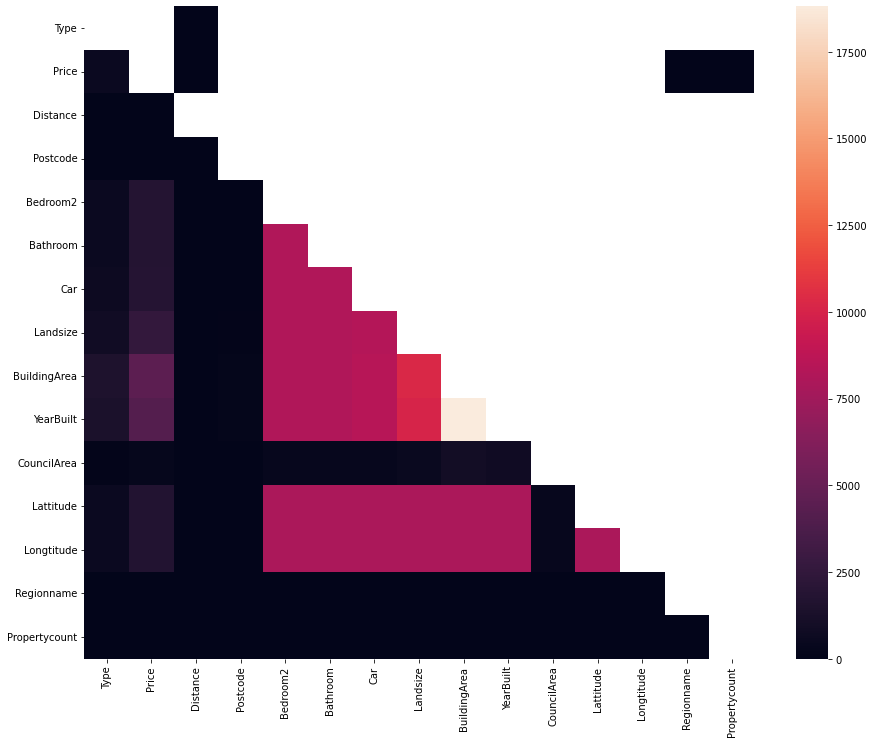

In [15]:
matplotlib.rcParams['figure.figsize'] = [15,12]
df = pd.DataFrame(columns=housing_nan.columns, index =housing_nan.columns)
for col1 in housing_nan.columns:
    for col2 in housing_nan.columns:
        df.loc[col1,col2] = housing_nan[(housing_nan[col1].isnull()) & (housing_nan[col2].isnull())].shape[0]
df = df.loc[:, (df != 0).any(axis=0)] 
df = df.loc[(df != 0).any(axis=1),:] 
df = df.astype(np.number)
matrix = np.triu(df)

sns.heatmap(df, mask=matrix);

### 4.	Handling missing values

**2.	Drop missing values. **

In [16]:
housing_nan.shape

(34857, 21)

In [17]:
housing_nan['indicator'] = [1 if (housing_nan.loc[i,['YearBuilt','BuildingArea']].isnull().sum()!=0) 
                            else 0 
                            for i in range(housing_nan.shape[0])]

In [18]:
housing_nan['weight'] = [1-(housing_nan.iloc[i,:].isnull().sum()/housing_nan.shape[1])
                         for i in range(housing_nan.shape[0])]

In [19]:
housing_nan.shape

(34857, 23)

In [20]:
housing_nan.dropna(axis=0, how='any', subset=["Price"], inplace=True)
housing_nan.dropna(axis=1, how='any', thresh = 0.5*housing_nan.shape[0], inplace=True)
housing_nan.dropna(axis=0, how='any', thresh = 0.5*housing_nan.shape[1], inplace=True)

In [21]:
housing_nan.shape

(27246, 21)

**3.	Imputation with a single value.**

In [22]:
housing_nan['Car'].fillna(housing_nan['Car'].median(), inplace=True)
housing_nan['Type'].fillna(housing_nan['Type'].mode()[0], inplace=True)
housing_nan['Postcode'].fillna(0, inplace=True)

**4. Forward and backward filling**

In [23]:
housing_nan.sort_values(by=["Postcode"], ascending=True, inplace=True)
housing_nan["CouncilArea"] = housing_nan["CouncilArea"].ffill()

**5.	Model-based imputation.**

In [24]:
df = housing_nan[['Rooms', 'Price', 'Distance', 'Car', 'Propertycount','Lattitude','Longtitude']].copy()
df.reset_index(drop=True, inplace=True)
df_em = pd.DataFrame(data = impy.em(df.values, loops=100), columns = df.columns)                     
housing_nan[['Lattitude','Longtitude']] = df_em[['Lattitude','Longtitude']].values

In [25]:
df = housing_nan[['Rooms', 'Price', 'Distance', 'Car', 'Propertycount', 'Landsize']].copy()
df.reset_index(drop=True, inplace=True)

scaler = MinMaxScaler()
df_mm = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
imputer = KNNImputer(n_neighbors=5)
df_temp = pd.DataFrame(imputer.fit_transform(df_mm), columns = df_mm.columns)
df_knn = pd.DataFrame(scaler.inverse_transform(df_temp), columns = df_temp.columns)
housing_nan[['Landsize']] = df_knn[['Landsize']].values

**6.	Multiple imputation.**

## Numerical features

### 1.	Description of the data distribution

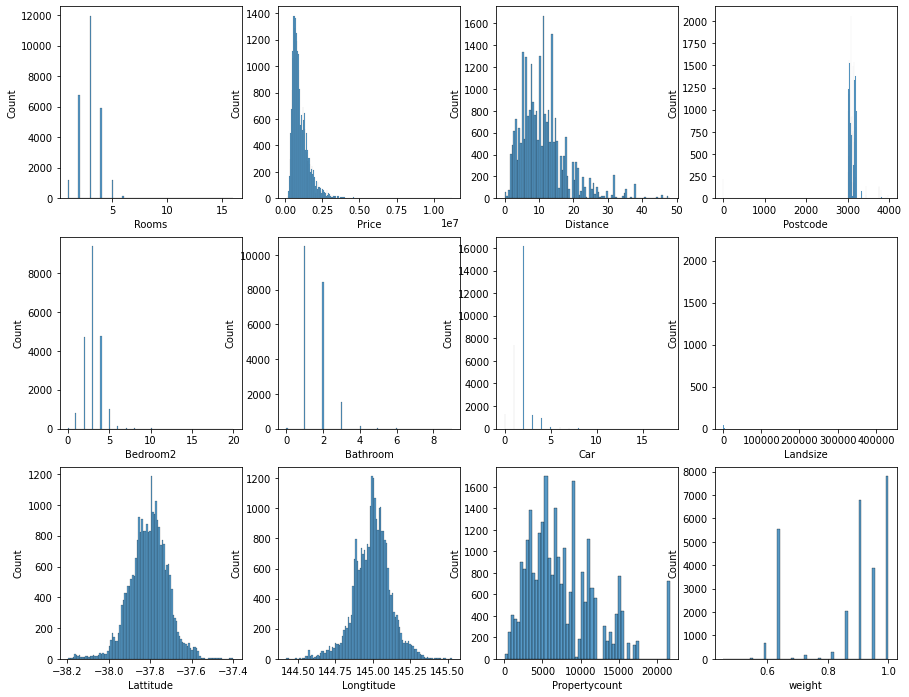

In [26]:
df = housing_nan[[col for col in housing_nan.columns if np.dtype(housing_nan[col])==float]]
grid_rows = 3
grid_cols = df.shape[1]/grid_rows

matplotlib.rcParams['figure.figsize'] = [15,12]
fig = plt.figure()
i=1
for col in df.columns:
    ax = fig.add_subplot(grid_rows, int(np.ceil(grid_cols)), i)
    sns.histplot(data=housing_nan[col])
    i+=1
plt.show();

In [27]:
df_num = pd.DataFrame(data= {col : {'skew': skew(housing_nan[col]),
                                'mode':housing_nan[col].mode()[0], 
                                'median':housing_nan[col].median()} 
                    for col in housing_nan.columns 
                    if np.dtype(housing_nan[col])==float}).T
num_stats = pd.concat([df_num, housing_nan.describe().T.iloc[:,1:]], axis=1)
num_stats

,skew,mode,median,mean,std,min,25%,50%,75%,max
Rooms,0.511240,3.0000,3.000000,2.992292e+00,0.954813,1.000000,2.000000,3.000000,4.000000e+00,1.600000e+01
Price,2.588781,600000.0000,870000.000000,1.050189e+06,641473.509016,85000.000000,635000.000000,870000.000000,1.295000e+06,1.120000e+07
Distance,1.478684,11.2000,10.500000,1.128028e+01,6.787469,0.000000,6.400000,10.500000,1.400000e+01,4.810000e+01
Postcode,-8.662588,3073.0000,3087.000000,3.089264e+03,296.265788,0.000000,3046.000000,3087.000000,3.152000e+03,3.978000e+03
Bedroom2,NaN,3.0000,3.000000,3.046237e+00,0.955122,0.000000,2.000000,3.000000,4.000000e+00,2.000000e+01
Bathroom,NaN,1.0000,1.000000,1.591683e+00,0.700880,0.000000,1.000000,1.000000,2.000000e+00,9.000000e+00
Car,1.598666,2.0000,2.000000,1.786648e+00,0.869558,0.000000,1.000000,2.000000,2.000000e+00,1.800000e+01
Landsize,104.314196,0.0000,504.400000,5.890573e+02,3122.418026,0.000000,250.050000,504.400000,6.540000e+02,4.330140e+05
Lattitude,-0.251965,-37.8361,-37.802000,-3.780677e+01,0.091568,-38.197697,-37.862167,-37.802000,-3.774762e+01,-3.739780e+01
Longtitude,-0.281139,144.9966,145.002300,1.449966e+02,0.120733,144.423790,144.923005,145.002300,1.450705e+02,1.455264e+02


### 2.	Normality testing

**1.	 Q-Q plot visualization**

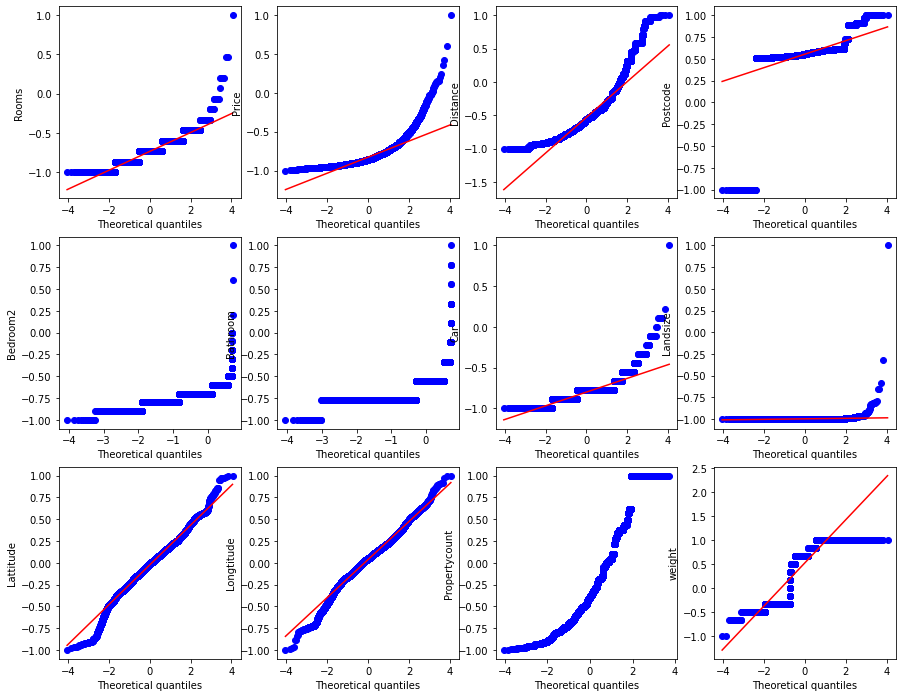

In [30]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_mm = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

grid_rows = 3
grid_cols = df.shape[1]/grid_rows

matplotlib.rcParams['figure.figsize'] = [15,12]
fig = plt.figure()
i=1
for col in df_mm.columns:
    ax = fig.add_subplot(grid_rows, int(np.ceil(grid_cols)), i)
    probplot(df_mm[col].values, dist="norm", plot=plt)
    plt.title(None)
    plt.ylabel(col)
    i+=1
plt.show();

**2.	Statistical testing for normality**

In [31]:
d = {'name':[],'statistic':[],'pvalue':[]}
for col in df.columns:
    d['name'].append(col)
    stat, p = normaltest(df[col])
    d['statistic'].append(stat)
    d['pvalue'].append(p)
pd.DataFrame(data=d)

,name,statistic,pvalue
0,Rooms,2860.997523,0.000000e+00
1,Price,16075.813276,0.000000e+00
2,Distance,7778.452479,0.000000e+00
3,Postcode,38734.803741,0.000000e+00
4,Bedroom2,NaN,NaN
5,Bathroom,NaN,NaN
6,Car,11333.912289,0.000000e+00
7,Landsize,109719.917059,0.000000e+00
8,Lattitude,870.948670,7.514486e-190
9,Longtitude,943.009063,1.691157e-205


### 3.	Skewed distributions and outliers

**1.	Dropping outliers.**

In [32]:
housing_nan = housing_nan[housing_nan["Postcode"]!=0]

**2.	Square root transformation**

In [33]:
housing_nan["Distance"] = np.sqrt(housing_nan["Distance"])

**3.	Log-transformation**

In [34]:
housing_nan["Price"] = np.log(housing_nan["Price"])

## Categorical features

### 1.	Data overview 

In [54]:
df2 = housing_nan[[col for col in housing_nan.columns if np.dtype(housing_nan[col])==object]]

cardinality = pd.DataFrame(data={col : {'cardinality': len(df2[col].unique()),
                                        'equal share': round(df2.shape[0]/len(df2[col].unique()),2)} 
                                 for col in df2.columns}) 

cardinality

,Suburb,Address,Type,Method,SellerG,CouncilArea,Regionname
cardinality,344.00,26549.00,3.00,5.0,348.00,33.00,9.00
equal share,78.58,1.02,9010.67,5406.4,77.68,819.15,3003.56


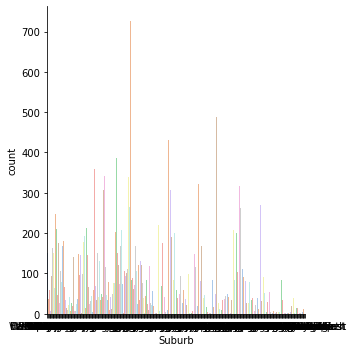

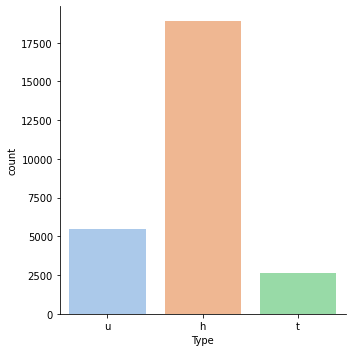

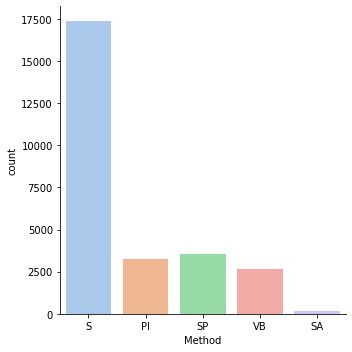

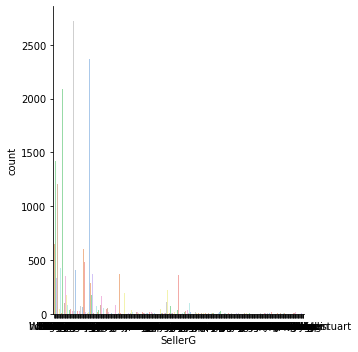

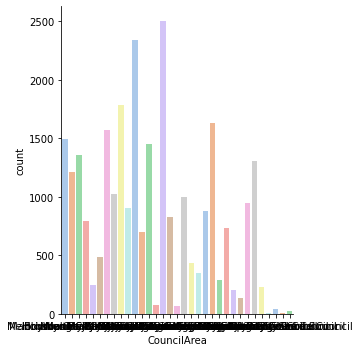

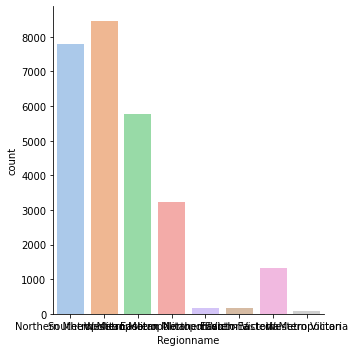

In [61]:
df3 = df2.drop(axis=1, columns='Address')

for col in df3.columns:
    sns.catplot(x=col , kind="count", palette="pastel", data=df3)
    plt.show();

### 2.	High Cardinality features

In [114]:
col = 'CouncilArea'
cat_dist = df3.groupby(col).size().sort_values(ascending=False)
to_group = cat_dist.where(cat_dist<=500).dropna().index
housing_nan[col] = [val if val not in to_group else 'other' for val in housing_nan[col]]

### 3.	Data encoding

In [116]:
dummy = pd.get_dummies(df3['Type'])
housing_nan = pd.concat([housing_nan.drop(columns=['Type']), dummy])